# DotArray: Alternative Class Construction

In this jupyter notebook we briefly show how to use alternative methods for creating
DotArray object instances.

First import the relevant modules,

In [1]:
import os
from pathlib import Path
path = Path(os.getcwd())

# update base working directory to QuDiPy
if path.stem != 'QuDiPy':
    base_dir = path.parents[1]
    os.chdir(base_dir)
else:
    base_dir = path

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qudipy.system import DotArray
from qudipy.utils import constants

## 1. Define DotArray Object Using Simulated Potentials

The most common method for constructing dot array objects is to use simulated
electrostatic potentials from finite element solvers. This method for dot array
object creation consists of:

1) Defining the path to the raw 3D potential data, the desired directory to save
2D potential slices, and a directory that <span style="color:red">*MIGHT*</span> exist containing the 2D potential
data. If the pre-processed data does not exist, then it will be generated under
a directory with the name specified in `preprocessed_dir`.

In [3]:
nav_dir = os.path.join('QuDiPy data', 'tutorials')
nextnano_dir = os.path.join(base_dir, nav_dir,
                                    'nextnano','2QD_dotsep_60nm')
processed_dir = os.path.join(base_dir, nav_dir,
                            'processed','2QD_processed')

2) Specify the gate contact names used when defining devices in the finite element
software package Nextnano++ and the expected number of quantum dot confinement 
potentials.

In [4]:
n_dots = 2      # anticipated number of dots

3) Specify the range of voltage values to use un subsequent calculations. This range 
can be the full range of simulated Nextnano++ data **or** a subset.

In [5]:
pts = [4,3,4]
ctrl_vals = [ 
    np.linspace(0.2, 0.45, pts[0]),
    np.linspace(-0.1, 0.15, pts[1]),
    np.linspace(0.2, 0.45, pts[2])]

4) Define a prefix to add to files that might be calcualted during the dot array object
creation. 

In [6]:
file_prefix = 'tutorial'

5) Instantiate the basic dot array object and Load/Calculate desired effective parameters using the numeric class method.

In [7]:
# Calculate the effective parameters and/or load the masked potential 
# lanscapes as well as save 2D potential slices to Pre-processed directory
dots_numeric = DotArray(n_dots, ctrl_ranges=ctrl_vals)
dots_numeric.numeric(processed_dir, nextnano_dir, file_prefix)

Loading pre-calculated spin interpolators from
/home/zach/Documents/github/QuDiPy/QuDiPy data/tutorials/processed/2QD_processed/tutorial_spin_data_size_[4 3 4]_from_[ 0.2 -0.1  0.2]_to_[0.45 0.15 0.45].pkl


An example of plotting the resultant potential generated from the numeric method and 
Nextnano++ pre-processed data. We plot the electrostatic potential by specifying the potential interpolation object `potential`
generated by the numeric DotArray method and specifying proper units for plotting.

**Note:** Default units are SI

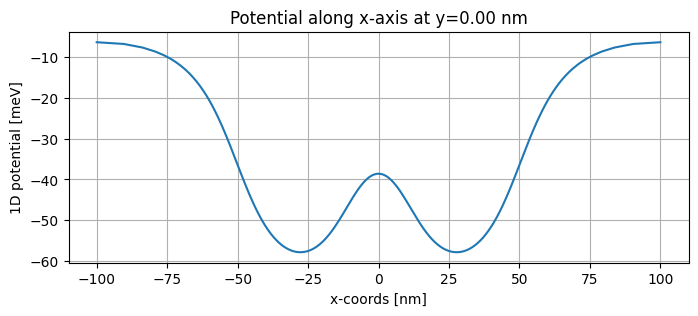

In [8]:

dots_numeric.potential.plot([0.2,0.0,0.2], plot_type='1D', y_slice=0, plot_units='meV')

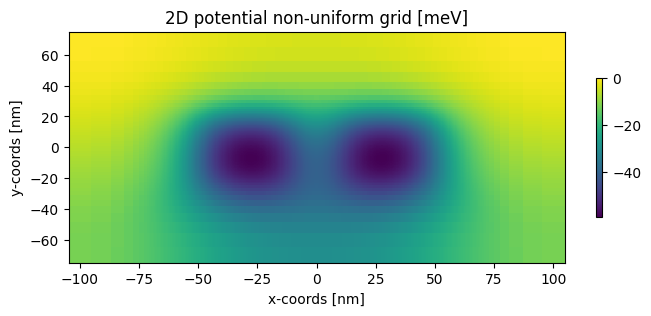

In [9]:
dots_numeric.potential.plot([0.2,0.0,0.2], plot_units='meV')

We can also plot the electric field by specifying the electric field interpolation object `e_field`
generated by the numeric DotArray method and specifying proper units for plotting.

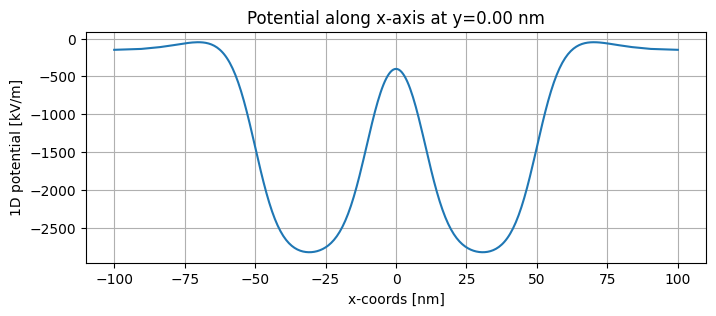

In [10]:
dots_numeric.e_field.plot([0.2,0.0,0.2], plot_type='1D', y_slice=0, plot_units='kV/m')

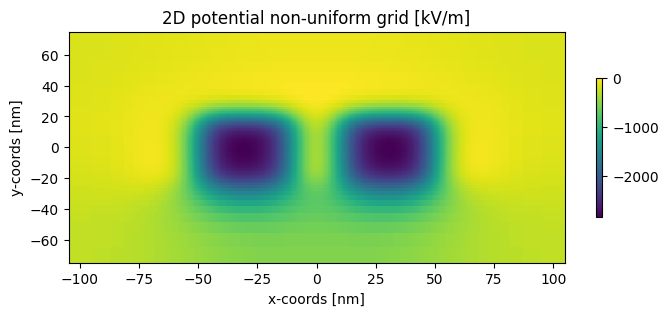

In [11]:
dots_numeric.e_field.plot([0.2,0.0,0.2], plot_units='kV/m')

## 2. Define DotArray Object Using Analytic Potentials

Instead of constructing a dot array objecting using simulated potentials, we can
define an analytic potential function parameterized by various control parameters.
The example below parameterizes the analytic potential using effective quantum 
dot size and dot separation.

In [12]:
# Bounds put on the maximum dot separation
a_min = 1e-10
a_max = 100e-9

# Defining control vector using dot seperation, dot sizes in frequency 
# representation, and bias voltage (this can be changed to account for electric
# field along x-axis)
sep = 90e-9
omega0 = 5e13
Vbias = 10
ctrl_val = [sep, omega0, Vbias]

### Quartic Potential For a Double Quantum Dot

In [13]:
# Simple double dot quartic potential
def create_quartic(ctrl_vals, coords, material='Si/SiO2'):

    from qudipy.utils import constants
    mat_system = constants.select_material(material)

    # If desired, bias can be incorperated into this analytic potential with v_bias
    scale = 10 # scale influences strength of bias voltage on potential
    a, omega_0, v_bias = ctrl_vals[0], ctrl_vals[1], ctrl_vals[2]

    x,y = coords['x'], coords['y']
    x_mesh, y_mesh = np.meshgrid(x,y)

    return (0.5 * mat_system.me * omega_0 ** 2 *  ( 
        1 / ( 4 * a **2) * ( (x_mesh ** 2 - a ** 2) ** 2)
        + y_mesh ** 2 ) 
        + (scale*0.5*(constants.e*v_bias)/a)*(x_mesh + a))
        

ctrl_vals = [list(np.linspace(a_min,a_max,25)),list(np.linspace(1e1,1e17, 25)), list(np.linspace(0,10, 10))]
ctrl_names = ['sep','omegao', 'Vb']
pot_func = create_quartic

coords = {'x':[], 'y':[]}
coords['x'] = np.linspace(-1.5*a_max, 1.5*a_max, 200)
coords['y'] = np.linspace(-1.5*a_max, 1.5*a_max, 200)

dots_analytic = DotArray(n_dots, ctrl_ranges=ctrl_vals)
dots_analytic.analytic(pot_func, coords=coords, ctrl_names=ctrl_names)

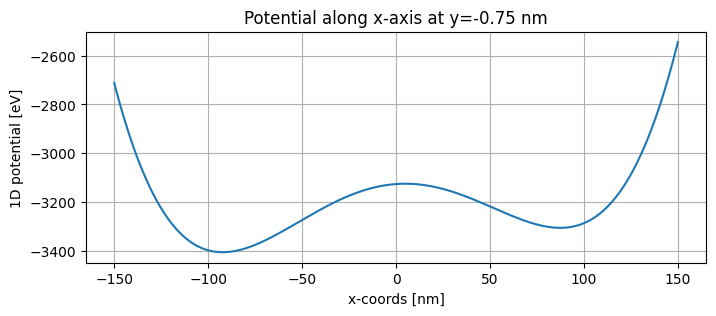

In [14]:
dots_analytic.potential.plot(ctrl_val, plot_type='1D', y_slice=0, plot_units=['eV'])

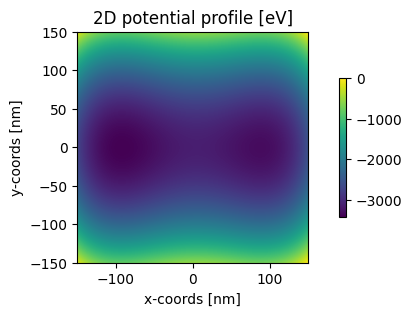

In [15]:
dots_analytic.potential.plot(ctrl_val, plot_units=['eV'])